# Fake Data Baysean Variable Analysis

This analysis examines Long Covid (L.C.) prevalence across U.S. states and the District of Columbia, based on data from the U.S. Centers for Disease Control and Prevention (CDC) as of February 2024. We will explore potential predictors of L.C. rates and investigate statistical relationships between these factors. The dataset was curated by Julia Moore Vogel, and this analysis was conducted by Ashley Yaner. As advised by Julia Vogel, Baysian Variable selection, a statistical method used to identify the most relevant predictors or variables in a dataset, will be used to understand the most prevelant factors contributing to the rates of COVID per state. ---> Wordage similar to Bobby's

# Imports

Import packages

In [441]:
# !pip install pymc
# !pip install arviz --upgrade

In [10]:
import pandas as pd
import re
import numpy as np
import datetime

# For plotting
import seaborn as sns  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

 # For dendrogram
import scipy.stats as stats
import scipy.cluster.hierarchy as shc 

# For Baysean variable selection
import pymc as pm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import arviz as az

# For inspecting and saving inference results
import xarray as xr
import json

In [11]:
# Set options for displaying all columns and rows in dataframe for later inspection
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

In [12]:
# Check pymc version for environmental package consistancy
pm.__version__

'5.16.2'

# Generate Fake Data for Testing the BVS Algorithm

In [13]:
def generate_fake_data_with_specific_impact(
    num_samples: int = 52,
    num_predictors: int = 12,
    seed: int = 42,
    influential_predictors: list = [3, 7],
    scale_factor: int = 2,
    shift: int = 10
):
    """Generates a fake dataset with specified number of samples, 
    predictors, and influential predictors.

    Args:
        num_samples (int):
            Number of data points.
            
        num_predictors (int):
            Number of predictor variables.
            
        seed (int):
            Random seed for reproducibility.
            
        influential_predictors (list):
            A list of indices indicating the influential predictors.

    Returns:
        A pandas DataFrame containing the generated data.
    """

    np.random.seed(seed)

    # # Generate predictor variables - normal fist
    predictors = pd.DataFrame({
        f"predictor_{i}": np.random.normal(
            loc=0,
            scale=0.5,
            size=num_samples
        )
        for i in range(1, num_predictors+1)
    })

    # Generate predictor variables - exponential dist
    # predictors = pd.DataFrame({
    #     f"predictor_{i}": np.random.exponential(
    #         scale=1,
    #         size=num_samples
    #     )
    #     for i in range(1, num_predictors+1)
    # })
    
    # Generate predictor variables - chi-squated dist
    # predictors = pd.DataFrame({
    #     f"predictor_{i}": np.random.chisquare(df=2, size=num_samples)
    #     for i in range(1, num_predictors+1)
    # })

    # Generate predictor variables - log-normal dist
    # predictors = pd.DataFrame({
    #     f"predictor_{i}": np.random.lognormal(
          # mean=0, sigma=1, size=num_samples)
    #     for i in range(1, num_predictors+1)
    # })   

    predictors[f"predictor_3"] *= 1000
    predictors[f"predictor_7"] *= -1000

    # Generate target variable. Shift, scale, randomness, noise
    # Random normal is Gaussian distribution noise
    target = np.abs(
        (predictors.sum(axis=1) + shift) * scale_factor + np.random.normal(
        loc=0,  # mean of distribution
        scale=0.5,  # std of distribution
        size=num_samples  # random numbers generated
    )) - predictors["predictor_7"] + predictors[f"predictor_3"]

    # Combine predictors and target
    data = pd.concat(
        [predictors,
         pd.Series(target, name="target")],
        axis=1
    )

    return data

Generate fake data. It'll be the same every time. 

In [14]:
df = generate_fake_data_with_specific_impact(
    num_samples = 52,  # Number of states in US + DoC + US = total num states in Household Pulse State col
    num_predictors = 12,  # Num of predictors in household pulse data
    seed = 42,  # Random number see. 42 is the ultimate question of life, the universe, and everything
    influential_predictors = [3, 7]  # Predictors I KNOW will influence the target the most
)

In [15]:
df.head(10)

predictor_1  predictor_2  predictor_3  predictor_4  predictor_5  \
0     0.248357    -0.338461   -80.642856     0.932887     0.257524   
1    -0.069132     0.305838   202.025428     0.236916     1.926366   
2     0.323844     0.515500   943.092951    -0.595652     0.285445   
3     0.761515     0.465640    87.288906     0.328277     0.567783   
4    -0.117077    -0.419609   128.775195    -0.487341     0.477001   
5    -0.117068    -0.154606   -37.222958     0.393542     0.325696   
6     0.789606     0.165632  -959.385608     0.579298    -0.157635   
7     0.383717     0.487773   -13.256938    -0.410341     0.379485   
8    -0.234737    -0.239587    30.115105     0.481688    -0.386413   
9     0.271280    -0.092829  1231.621056     0.206390    -0.118409   

   predictor_6  predictor_7  predictor_8  predictor_9  predictor_10  \
0    -0.463465  -412.708174     0.345072     0.775576     -0.265251   
1    -0.029763  -406.754818    -0.200610     0.057837     -0.287909   
2    -1.620634  -652.739404     0.112046     0.589649     -0.137526   
3    -0.512194   -10.501921     0.006296     0.033759     -1.150961   
4    -0.126284  -340.976486     0.048838     1.030374     -0.757596   
5    -0.623892   155.133378    -0.386505     0.877670      0.683437   
6     0.816206  -162.083176     0.012255    -0.124482      0.822484   
7    -0.715071    65.071527     0.248999     0.485785     -0.124518   
8    -0.220022   -48.497982     0.725572     0.322688      0.288278   
9     0.065370  -297.578513     0.479635     0.684316      0.155625   

   predictor_11  predictor_12       target  
0     -0.834703      0.163464  1296.328785  
1      0.271680     -0.109550   994.291287  
2     -0.331312      0.414703  2195.156773  
3      0.285299     -1.105568   270.661600  
4     -0.381630      0.117807   875.357430  
5     -0.902441      0.385433    64.974132  
6     -0.813771     -0.739293  1423.780770  
7      0.024042      0.571877    48.728987  
8      0.129861      0.169248    93.384693  
9     -0.452158     -0.207644  3419.054367

Print out summary stats for each column

In [16]:
df.describe()

predictor_1  predictor_2  predictor_3  predictor_4  predictor_5  \
count    52.000000    52.000000    52.000000    52.000000    52.000000   
mean     -0.108987    -0.019529     7.158852     0.059959     0.080437   
std       0.459324     0.443262   489.811426     0.461662     0.567213   
min      -0.979835    -1.309873  -959.385608    -0.757424    -1.012571   
25%      -0.383445    -0.260571  -365.788443    -0.408514    -0.327722   
50%      -0.117073    -0.026959    68.557294     0.122696     0.067082   
75%       0.164484     0.268935   242.839857     0.335458     0.397042   
max       0.926139     0.782322  1231.621056     1.360085     1.926366   

       predictor_6  predictor_7  predictor_8  predictor_9  predictor_10  \
count    52.000000    52.000000    52.000000    52.000000     52.000000   
mean     -0.016034   -25.267818     0.023552    -0.000587     -0.035191   
std       0.491451   392.548535     0.508157     0.524843      0.530398   
min      -1.620634 -1046.193638    -1.061948    -1.033721     -1.150961   
25%      -0.296866  -301.198862    -0.375574    -0.414812     -0.430980   
50%      -0.002667    -2.189267     0.017873    -0.022061     -0.107322   
75%       0.307592   260.569260     0.347756     0.346962      0.283183   
max       1.066517   724.042171     1.094901     1.030374      1.539440   

       predictor_11  predictor_12       target  
count     52.000000     52.000000    52.000000  
mean      -0.103061      0.093884   912.378943  
std        0.491298      0.493450  1054.404277  
min       -1.235822     -1.105568 -1132.547633  
25%       -0.385834     -0.231968   322.623812  
50%       -0.132267      0.132047   841.124789  
75%        0.214145      0.380229  1376.045057  
max        1.037700      1.222876  3647.117950

In [17]:
lc_rates = df[["target"]]
lc_rates.head(10)

target
0  1296.328785
1   994.291287
2  2195.156773
3   270.661600
4   875.357430
5    64.974132
6  1423.780770
7    48.728987
8    93.384693
9  3419.054367

# Plot Scatter Plot to see correlations

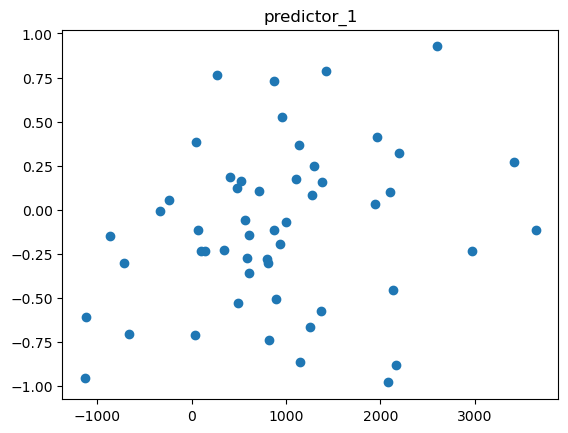

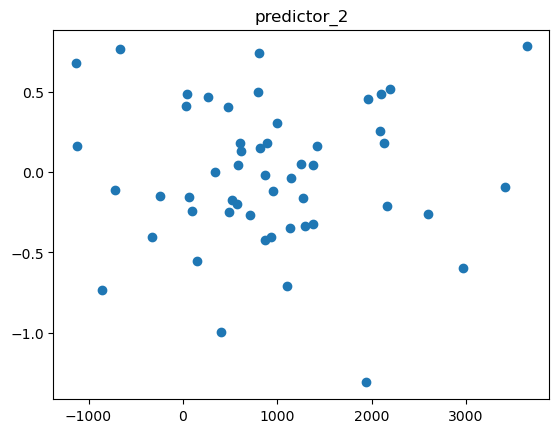

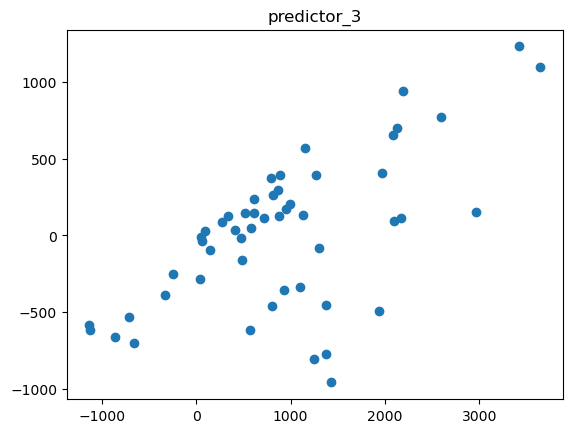

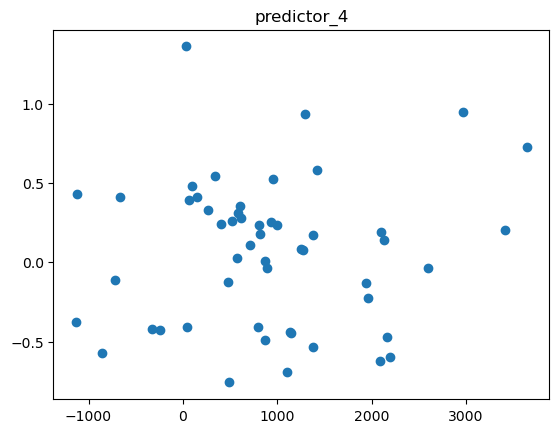

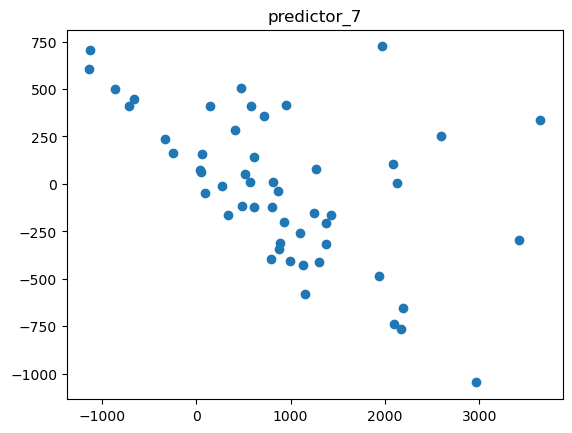

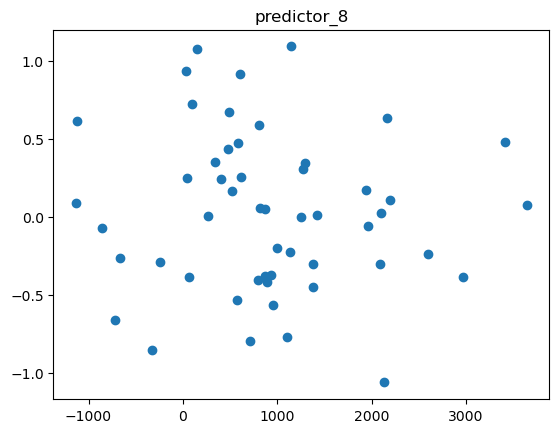

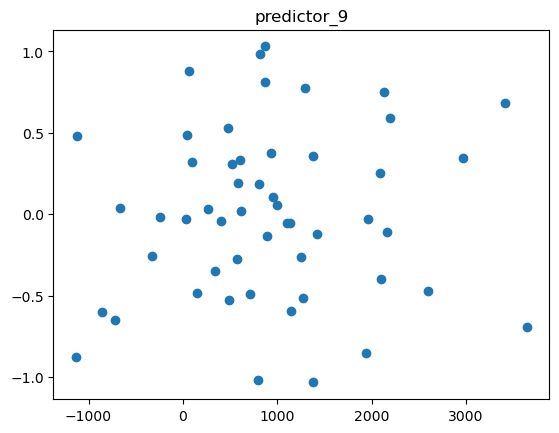

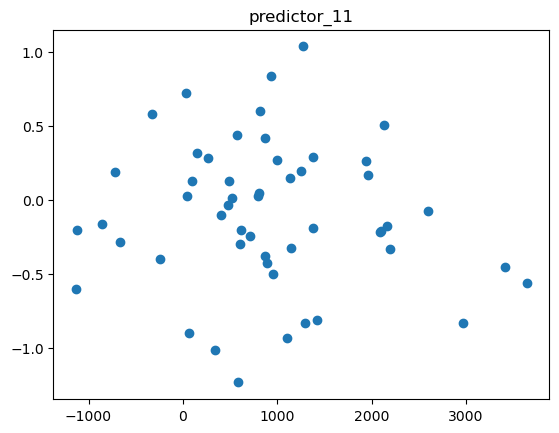

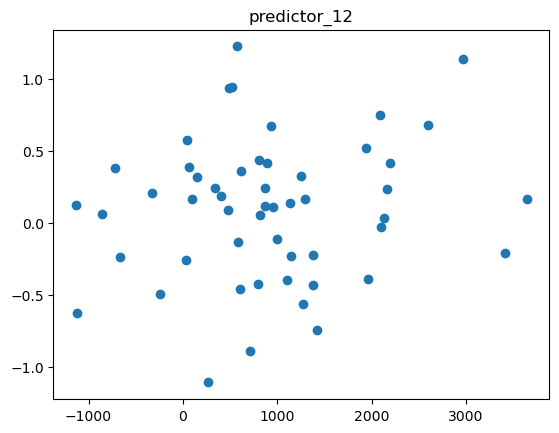

In [19]:
predict_cols = [col for col in df.columns if 'predictor' in col]

for var in df[predict_cols].columns: 
    plt.scatter(lc_rates[["target"]], df[[var]])
    plt.title(var)
    plt.show()

## Convert matrix to vector
Flatten dataframe for qq plotting

## Compute Zscore

In [20]:
def compute_zscore_df(
    df: pd.DataFrame,
    fill_missing_vals: bool = True
) -> pd.DataFrame:
    """Computes the z-score for all columns in a pandas DataFrame
  
    Args:
        df (pd.DataFrame):
            A pandas DataFrame.
            
        fill_missing_vals (bool):
            If true, then fill missing values with mean of zscores.
            Otherwise, fill missing values with NaNs (not a number)>

    Returns:
        df_z_score (pd.DataFrame): 
            A new pandas DataFrame with the z-scores of each column.

    Typical Usage Example:
        Take a DataFrame and a column name as input, calculate the mean
        and standard deviation of the specified column, and return a new
        pandas Series containing the z-scores. This allows you to easily
        apply the z-score calculation to specific columns within your
        DataFrame.    
        
        df_z_scores =  compute_zscore_df(df)
  """

    # Select numeric columns only
    numeric_df = df.select_dtypes(include=[np.number])

    # Calculate mean and standard deviation for numeric columns
    df_means = numeric_df.mean(skipna=True)
    df_stds = numeric_df.std(skipna=True)

    # Calculate z-scores for numeric columns
    z_scores = (df[numeric_df.columns] - df_means) / df_stds
    
    if fill_missing_vals:
        # Fill in missing values with mean of zscore
        z_scores.fillna(z_scores.mean(), inplace=True)
    else: 
        # Fill missing values in z-scores with NaN
        z_scores.fillna(np.nan, inplace=True)

    return z_scores

### Compute Z-Score 


In [21]:
df_z_score = compute_zscore_df(df)

In [22]:
lc_rates_zscore = compute_zscore_df(lc_rates)

In [23]:
lc_rates_zscore.head(10)

target
0  0.364139
1  0.077686
2  1.216590
3 -0.608607
4 -0.035111
5 -0.803681
6  0.485015
7 -0.819088
8 -0.776736
9  2.377338

In [24]:
# lc_rates_flat_z_scores.head(20)

In [25]:
# print(f"Is NaN: {np.isnan(lc_rates_flat_z_scores).any()}")  # Checks for NaNs
# print(f"Is INF: {np.isinf(lc_rates_flat_z_scores).any()}")  # Checks for infinities
# print(f"Has Zeros: {(lc_rates_flat_z_scores == 0).any()}")  # Checks for infinities
# print(lc_rates_flat_z_scores.dtype)

# print(f"Is NaN: {np.isnan(lc_rates_zscore).any()}")  # Checks for NaNs
# print(f"Is INF: {np.isinf(lc_rates_zscore).any()}")  # Checks for infinities
# print(f"Has Zeros: {(lc_rates_zscore == 0).any()}")  # Checks for infinities

# Q-Q Plot

In [26]:
def create_qq_plot(
    data: pd.Series
) -> None:
    """Creates a Q-Q plot of the specified Long COVID rate data.

    Args:
        lc_rates (pd.Series):
            A pandas Series containing the Z-Score of the 
            Long COVID rate data.

    Returns:
        None: The function directly creates the plot.
        
    Typical Usage Example: 
        It's often used to assess whether a dataset follows a particular
        theoretical distribution (e.g., normal, lognormal, uniform).
        If the plot is a straight line, it suggests that the two
        distributions are similar. If the plot is not a straight line, it
        indicates that the distributions are different. Deviations from the
        line can reveal the nature of the differences (e.g., skewness, kurtosis).
        
        create_qq_plot(lc_rates_flat_z_scores)

    """

    theoretical_quantiles = stats.norm.ppf(stats.rankdata(data) / (len(data) + 1))

    print(f"theoretical_quantiles min: {theoretical_quantiles.min()}, "\
          f"max: {theoretical_quantiles.max()}")
    print(f"data min: {data.min()}, max: {data.max()}")
    print(f"len(data): {len(data)}")
    
    plt.figure(figsize=(7, 7))

    # Add QQ line and data
    stats.probplot(data, dist="norm", plot=plt)
    
    # Access the scatter plot created by probplot
    scatter_plot = plt.gca().get_children()[0]
    
    # Modify the scatter plot properties
    scatter_plot.set_marker('o')  # Set marker to circles
    scatter_plot.set_markeredgecolor('black')  # Set edge color to black
    scatter_plot.set_markerfacecolor('white')  # Set face color to white for hollow
    scatter_plot.set_markersize(4)  # Adjust the marker size as needed

    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title("Normal Q-Q Plot")
    plt.grid(False)
    
    plt.show()

In [27]:
# create_qq_plot(lc_rates)

## Dendrogram

In [28]:
def dendrogram(data: pd.DataFrame) -> None:
    """Creates a visualization of hierarchical clustering for
    household pulse long COVID rate data.

    Args:
        data (pd.DataFrame):
            A DataFrame containing z-score normalized household 
            pulse long COVID rate data. Each column represents a 
            state and the index represents the time period.

    Returns:
        None:
            This function creates a plot and does not return any value.
    
    Typical Usage Example: 
        It assumes the DataFrame contains z-score normalized household
        pulse long COVID rate data. Each column represents a state and
        the index represents the time period.
        
        Dendrogram: The dendrogram on the left side of the plot visually
        represents the hierarchical clustering of the data points
        (states, in this case). The height of the branches in the dendrogram
        indicates the similarity or dissimilarity between the clusters.
        
        Heatmap: The heatmap on the right side of the plot displays the values
        of the data points (long COVID rates) in a color-coded matrix. The
        colors represent the magnitude of the values, with darker colors
        indicating higher values.
        
        dendrogram(lc_rates_zscore)
    """
    
    
    # Calculate the linkage matrix
    distance_matrix = shc.distance.pdist(data)  # Use pairwise distances
    linkage_matrix = shc.linkage(distance_matrix, method='ward')

    # Create the figure with a smaller size
    fig = plt.figure(figsize=(11, 7))
    fig.suptitle("Dendrogram: ZScore Long COVID Rate Dates vs States")
    # Create a gridspec layout
    gs = gridspec.GridSpec(
        1,
        2,
        width_ratios=[15, 85],
        figure=fig,
        wspace=0
    )

    axs = gs.subplots(sharex='col')
        
    # Create the dendrogram
    # axs[0] = plt.subplot(gs[0])
    dendrogram = shc.dendrogram(
        linkage_matrix,
        orientation='left',
        no_labels=True,
        ax=axs[0]
    )
    
    # Plot heatmap
    # axs[1] = plt.subplot(gs[1], sharex=ax1)
    
    data_index = data.index
    data_col_names = data.columns
    
    # Remove "State" from idx
    data = data.reset_index(drop=True)
    
    axs[1] = sns.heatmap(
        data,
        cbar=True,  # Display colorbar
        cmap="Reds",  # Choose a colormap (adjust as needed)
        linewidths=0.0,  # No lines between cells
        xticklabels=True,  # Show x-axis labels
        yticklabels=False,  # Don't show y-axis labels
        cbar_kws={'pad': 0.22, 'fraction': 0.1},  # colorbar size and spacing
        center=True
    )
    
    # Add y-axis labels to the right
    # Set the y-axis ticks and labels for ax[1]
    axs[1].set_yticks(range(len(data)))
    axs[1].set_yticklabels(data_index)

    # Set the y-axis ticks and labels for ax[1]
    axs[1].set_xticks(range(len(data_col_names)))
    axs[1].set_xticklabels(data_col_names)

    # Adjust the y-axis position for ax[1]
    axs[1].yaxis.tick_right()

    axs[1].tick_params(axis="y", left=False, labelleft=False) 
    
    plt.show()


In [29]:
# dendrogram(lc_rates)

# Get predictor variables
Separate predictor variables from dataframe

In [30]:
df_variables = df_without_column2 = df.drop('target', axis=1)
df_variables.head(10)

predictor_1  predictor_2  predictor_3  predictor_4  predictor_5  \
0     0.248357    -0.338461   -80.642856     0.932887     0.257524   
1    -0.069132     0.305838   202.025428     0.236916     1.926366   
2     0.323844     0.515500   943.092951    -0.595652     0.285445   
3     0.761515     0.465640    87.288906     0.328277     0.567783   
4    -0.117077    -0.419609   128.775195    -0.487341     0.477001   
5    -0.117068    -0.154606   -37.222958     0.393542     0.325696   
6     0.789606     0.165632  -959.385608     0.579298    -0.157635   
7     0.383717     0.487773   -13.256938    -0.410341     0.379485   
8    -0.234737    -0.239587    30.115105     0.481688    -0.386413   
9     0.271280    -0.092829  1231.621056     0.206390    -0.118409   

   predictor_6  predictor_7  predictor_8  predictor_9  predictor_10  \
0    -0.463465  -412.708174     0.345072     0.775576     -0.265251   
1    -0.029763  -406.754818    -0.200610     0.057837     -0.287909   
2    -1.620634  -652.739404     0.112046     0.589649     -0.137526   
3    -0.512194   -10.501921     0.006296     0.033759     -1.150961   
4    -0.126284  -340.976486     0.048838     1.030374     -0.757596   
5    -0.623892   155.133378    -0.386505     0.877670      0.683437   
6     0.816206  -162.083176     0.012255    -0.124482      0.822484   
7    -0.715071    65.071527     0.248999     0.485785     -0.124518   
8    -0.220022   -48.497982     0.725572     0.322688      0.288278   
9     0.065370  -297.578513     0.479635     0.684316      0.155625   

   predictor_11  predictor_12  
0     -0.834703      0.163464  
1      0.271680     -0.109550  
2     -0.331312      0.414703  
3      0.285299     -1.105568  
4     -0.381630      0.117807  
5     -0.902441      0.385433  
6     -0.813771     -0.739293  
7      0.024042      0.571877  
8      0.129861      0.169248  
9     -0.452158     -0.207644

# Bayesian Variable Selection

In [31]:
def save_inference_arviz_to_df(
    inferece_results_az:  az.InferenceData,
    target_name: str,
    model_params: dict,
    experiment_name: str
) -> None:
    """Saves BVS results and model parameters to csv.
        
    Args: 
        inferece_results_az (az.InferenceData):
            Inference results from BVS.
        
        target_name (str): 
            The name of the file to save the inference data. 
            
        model_params (dict): 
            Dictionary of model parameters associated with the 
            inference results.
    
        experiment_name (str, optional): 
            If you want to add a name to the saved file names to help 
            you more easily identify your experiment, then add it here.
            
    Typical Usage Example: 
        This function is called by the main baysean variable 
        selection funcion. No need to call this separately. 
    
    """
    # Convert inference arviz data type to pandas datafram
    posterior_df  = inferece_results_az.to_dataframe()
    sample_stats_df = inferece_results_az.sample_stats.to_dataframe()
    observed_data_df = inferece_results_az.observed_data.to_dataframe()
    
    # Get current date so that we can keep track of when
    # the inference was run
    now = datetime.datetime.now()
    formatted_date = now.strftime('%m-%d-%Y_%H-%M-%S')
    
    suffix = f"{target_name}_{formatted_date}"
    
    # Save pandas dataframe to csv.
    posterior_df.to_csv(
        f'BVS_{experiment_name}_posterior_{suffix}.csv',
        index=False
    )
    
    # Save pandas dataframe to csv.
    sample_stats_df.to_csv(
        f'BVS_{experiment_name}_sample_stats_{suffix}.csv',
        index=False
    )    
    
    # Save pandas dataframe to csv.
    observed_data_df.to_csv(
        f'BVS_{experiment_name}_observed_data_{suffix}.csv',
        index=False
    )
    
    # Convert any non str or number values to str, For example, "kernel": pm.smc.IMH,
    # Convert pm.smc.IMH to "pm.smc.IMH" so that it's compatable with JSON saving
    
    params_to_save = model_params.copy()
    for param_key, param_value in params_to_save.items():
        if not isinstance(param_value, (str, int, float)):
            params_to_save[param_key] = str(param_value)      
    
    #Save parameters associated with the BVS
    with open(f'BVS_{experiment_name}_model_params_{suffix}.txt', 'w') as f:
        json.dump(params_to_save, f, indent=4)

In [32]:
def bayesian_variable_selection_multiple(
    df_vars: pd.DataFrame,
    df_values: pd.DataFrame,
    model_params: dict,
    experiment_name: str = "LC_household_pulse_v11" 
) -> list:
    """Performs Bayesian Variable Selection for multiple target
    variables in two pandas DataFrames, one containing variables and
    the other containing Long COVID rates (for different dates and also
    an accumulated avg).

    Args:
        df_vars (pandas.DataFrame):
            The input DataFrame containing the variables.

        df_values (pandas.DataFrame):
            The input DataFrame containing the Long COVID rates.

        model_params (dict):
            Dictionary of model parameters.

        experiment_name (str, optional): 
            If you want to add a name to the saved file names to help 
            you more easily identify your experiment, then add it here.
          
    Returns:
        traces (list):
            A list of PyMC trace objects, one for each target variable, 
            containing the Baysian Variable Selection results. 
            
    Typical Usage Example: 
        Call this function to perform BVS using predictor variables 
        DataFrame and a dataframe containing the desired target variables
        to model.
        
        model_params = {
            "beta": 1,
            "mu": 0,
            "sigma": 2,
            "prob_of_success": 0.2,
            "draws": 1500,
            "tune": 1500,
            "cores": 4,
            "target_accept": 0.95,
            "max_treedepth": 25
        }  

        all_variables_avg_10_v2 = bayesian_variable_selection_multiple(
            df_variables,
            pd.DataFrame(lc_rates['Avg']),
            model_params
        )
    """

    traces = []  # init list to store results of BVS
    
    # Iterate through columns in Long COVID rate dataframe
    for target_col in df_values.columns:

        trace = bayesian_variable_selection_with_dfs(
            df_vars,  # dataframe containing variables
            df_values[target_col],  # series containing Long COVID rates
            target_col,  # corresponding column header to rate values
            model_params # model parameters for BVS
        )
        
        traces.append(trace)  # append BVS results to list
        
        save_inference_arviz_to_df(
            inferece_results_az=trace,
            target_name=f"{target_col}",
            model_params=model_params,
            experiment_name=experiment_name
        )
        
    return traces

In [33]:
# def bayesian_variable_selection_with_dfs(
#     df_vars: pd.DataFrame,
#     series_values: pd.Series,
#     target_col: str, 
#     model_params: dict,
#     imputer_strategy='mean'
# ) -> pm.backends.base.MultiTrace:
#     """Performs Bayesian Variable Selection using PyMC3
#     on a pandas DataFrame containing variables and a pandas
#     Series containing Long COVID rates.

#     Args:
#       df_vars (pandas.DataFrame):
#           DataFrame containing variables afftecting/not
#           affecting Long COVID Rates.
          
#       series_values (pd.Series):
#           DataFrame containing Long COVID rates.
          
#       target_col (str):
#           The column name of the target column in df_values. 
#           This can contains either a specific date or avg of 
#           all dates of Long COVID rates.
          
#       model_params (dict):
#           Dictionary of model parameters.
          
#     Returns:
#       trace (pm.backends.base.MultiTrace):
#           A PyMC3 trace object containing the Baysian Variable
#           Selection results.
          
#     Typical Usage Example: 
#         This iterates through each target variable and performs BVS
#         using all predictor variables. 
        
#         Called by bayesian_variable_selection_multiple function
        
#         sampling kernel options: 
#             pm.smc.IMH: Independent Metropolis-Hastings sampler
#             pm.nuts: No-U-Turn Sampler
#             pm.hmc: Hamiltonian Monte Carlo
#     """
#     # Extract data from DataFrames
#     y = series_values.values  # Long COVID rates
#     X = df_vars.values  # Variables affecting/not affecting LC rates

#     # Impute missing values using SimpleImputer.
#     # Replace 'mean' with 'median' or 'most_frequent' if needed
#     imputer = SimpleImputer(strategy=imputer_strategy)  
#     X_imputed = imputer.fit_transform(X)    
    
#     n, p = X.shape

#     with pm.Model() as model:
#         # ------------------------------------------------------------------------------
#         # Priors
#         # ------------------------------------------------------------------------------
#         # sigma defines a prior distribution for the std of the noise term in the model.
#         # It uses a Gamma distribution with parameters alpha and beta. A higher alpha leads
#         # to a distribution that is more concentrated towards lower values of sigma
#         # (less noise). A higher beta leads to a distribution with larger
#         # standard deviations (more noise).
#         sigma = pm.Gamma(
#             'sigma',
#             alpha=model_params["alpha_sigma"],
#             beta=model_params["beta_sigma"]
#         )
        
#         # beta_raw defines a prior distribution for a vector of raw coefficients 
#         # associated with each feature in the data. It uses a normal distribution
#         # with a mean of 0 and a std of 1 for each element of beta_raw. A mean of
#         # 0 indicates a neutral prior, meaning it doesn't favor any particular
#         # value of the parameter. Setting std to 1 means the prior distribution
#         # is scale-invariant, meaning the choice of units doesn't affect the
#         # inference. The shape=p argument specifies that beta_raw will be a vector of 
#         # length p, where p is the number of features in your data.
#         beta_raw = pm.Normal(
#             'beta_raw',
#             mu=model_params["mu"],
#             sigma=model_params["sigma"],
#             shape=p
#         )
#         # ind defines a prior distribution for a vector of indicator variables
#         # for each feature. It uses a Bernoulli distribution with a probability of
#         # success (p=0.2) for each element of ind. This means there's a 20% chance for
#         # each element to be 1 (indicating inclusion) and an 80% chance to be 0
#         # (exclusion). Setting p=0.2 can be seen as a sparsity assumption, a form of 
#         # regularization, of for use in computational efficiency. Rgarding the sparsity
#         # assumption, many real-world problems exhibit sparsity, meaning only a small
#         # subset of features are truly informative. Rgarding regularization, setting 
#         # p=0.2, the model is encouraged to favor simpler models with fewer active
#         # features, which helps prevent overfitting. With respect to computational 
#         # efficiency, using a smaller p value can lead to computational efficiency gains,
#         # especially in high-dimensional problems, as it reduces the number of features
#         # that need to be considered. The shape=p argument ensures ind has the same
#         # length as beta_raw.
#         ind = pm.Bernoulli('ind', p=model_params["prob_of_success"], shape=p)
#         # This defines a deterministic variable (beta) that combines the raw
#         # coefficients (beta_raw) and the indicator variables (ind). The element-wise
#         # multiplication (*) ensures that features with corresponding ind values of 0
#         # get effectively set to 0 in beta. This is how variable selection is achieved
#         # through the interaction of priors. Features with low selection probability
#         # (low ind values) will have their coefficients shrunk towards 0 in the posterior
#         # distribution.
#         beta = pm.Deterministic('beta', beta_raw * ind)

#         # ------------------------------------------------------------------------------
#         # Likelihood
#         # ------------------------------------------------------------------------------
#         # mu defines a deterministic variable (mu) that represents the predicted mean of
#         # the response variable (y).It uses the dot product (pm.math.dot) between the
#         # imputed data matrix (X_imputed) and the coefficient vector (beta) to calculate
#         # the predicted means for each data point.
#         mu = pm.Deterministic('mu', pm.math.dot(X_imputed, beta))
#         # likelihood defines the likelihood function, representing the probability of 
#         # observing the actual data (y) given the predicted means (mu) and the assumed 
#         # noise distribution. It uses a normal distribution with the predicted means
#         # (mu) as the expected values and the standard deviation (sigma) from the 
#         # prior. The observed data (y) is used to compute the likelihood for each data
#         # point.
#         likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
        
#         # ------------------------------------------------------------------------------
#         # Sampling
#         # ------------------------------------------------------------------------------
#         # This performs Sequential Monte Carlo (SMC) to obtain samples from
#         # the posterior distribution of the model parameters. 
#         # Draws specifies the number of samples that you want the sampler to
#         # generate from the posterior distribution of your model's parameters.
#         # Kernel determines the algorithm used to generate the samples.
#         # Warmup is where initial samples are discarded before calculating diagnostics
        
#         trace = pm.sample_smc(
#             draws=model_params["draws"],  # Number of samples (previously nparticles)
#             kernel=model_params["kernel"],  # pm uses Independent Metropolis Hastings kernel
#             model=model,
#             # tune=model_params["warmup"],  # Use warmup steps for tuning
#             cores=model_params["cores"]
#         )
        
#     return trace



In [41]:
def bayesian_variable_selection_with_dfs(
    df_vars: pd.DataFrame,
    series_values: pd.Series,
    target_col: str, 
    model_params: dict,
    imputer_strategy='mean'
) -> pm.backends.base.MultiTrace:
    """Performs Bayesian Variable Selection using PyMC3
    on a pandas DataFrame containing variables and a pandas
    Series containing Long COVID rates.

    Args:
        df_vars (pandas.DataFrame):
            DataFrame containing variables afftecting/not
            affecting Long COVID Rates.

        series_values (pd.Series):
            DataFrame containing Long COVID rates.

        target_col (str):
            The column name of the target column in df_values. 
            This can contains either a specific date or avg of 
            all dates of Long COVID rates.

        model_params (dict):
            Dictionary of model parameters.
        
        scale_predictors (bool):
            Booling indicating whether or not to scale the predictor
            variables or not. For z-score, use StandardScaler. 
            For min-max, use MinMaxScaler. For robust scaling using 
            interquartile range, use RobustScaler. 
            
    Returns:
        trace (pm.backends.base.MultiTrace):
            A PyMC3 trace object containing the Baysian Variable
            Selection results.
          
    Typical Usage Example: 
        This iterates through each target variable and performs BVS
        using all predictor variables. 

        Called by bayesian_variable_selection_multiple function

        sampling kernel options: 
            pm.smc.IMH: Independent Metropolis-Hastings sampler
            pm.nuts: No-U-Turn Sampler
            pm.hmc: Hamiltonian Monte Carlo
        """
    # Extract data from DataFrames
    y = series_values.values  # Long COVID rates
    X = df_vars.values  # Variables affecting/not affecting LC rates

    # If scale predictor variables (df_vars)
    if model_params["scale_predictors"]: 
        # Z-score: If your data is normally distributed and you want to
        # preserve the relative distances between data points.
        if model_params["scale_function"] == "z-score": 
            scaler = StandardScaler() 
            
        # Min-Max: If you want to scale the data to a specific range
        elif model_params["scale_function"] == "min-max": 
            scaler = MinMaxScaler()
            
        # Robust: If your data contains outliers that might affect the scaling.
        elif model_params["scale_function"] == "robust": 
            scaler = RobustScaler()
            
        X_scaled = scaler.fit_transform(X)    
        
    else: 
        X_scaled = X
    
    # Impute missing values using SimpleImputer.
    # Replace 'mean' with 'median' or 'most_frequent' if needed
    imputer = SimpleImputer(strategy=imputer_strategy)  
    X_imputed = imputer.fit_transform(X_scaled)    
    
    n, p = X.shape

    with pm.Model() as model:
        # ------------------------------------------------------------------------------
        # Priors
        # ------------------------------------------------------------------------------
        # sigma defines a prior distribution for the std of the noise term in the model.
        # It uses a Gamma distribution with parameters alpha and beta. A higher alpha leads
        # to a distribution that is more concentrated towards lower values of sigma
        # (less noise). A higher beta leads to a distribution with larger
        # standard deviations (more noise).
        sigma = pm.Gamma(
            'sigma',
            alpha=model_params["alpha_sigma"],
            beta=model_params["beta_sigma"]
        )
        
        # beta_raw defines a prior distribution for a vector of raw coefficients 
        # associated with each feature in the data. It uses a normal distribution
        # with a mean of 0 and a std of 1 for each element of beta_raw. A mean of
        # 0 indicates a neutral prior, meaning it doesn't favor any particular
        # value of the parameter. Setting std to 1 means the prior distribution
        # is scale-invariant, meaning the choice of units doesn't affect the
        # inference. The shape=p argument specifies that beta_raw will be a vector of 
        # length p, where p is the number of features in your data.
        beta_raw = pm.Normal(
            'beta_raw',
            mu=model_params["mu"],
            sigma=model_params["sigma"],
            shape=p
        )
        # ind defines a prior distribution for a vector of indicator variables
        # for each feature. It uses a Bernoulli distribution with a probability of
        # success (p=0.2) for each element of ind. This means there's a 20% chance for
        # each element to be 1 (indicating inclusion) and an 80% chance to be 0
        # (exclusion). Setting p=0.2 can be seen as a sparsity assumption, a form of 
        # regularization, of for use in computational efficiency. Rgarding the sparsity
        # assumption, many real-world problems exhibit sparsity, meaning only a small
        # subset of features are truly informative. Rgarding regularization, setting 
        # p=0.2, the model is encouraged to favor simpler models with fewer active
        # features, which helps prevent overfitting. With respect to computational 
        # efficiency, using a smaller p value can lead to computational efficiency gains,
        # especially in high-dimensional problems, as it reduces the number of features
        # that need to be considered. The shape=p argument ensures ind has the same
        # length as beta_raw.
        ind = pm.Bernoulli('ind', p=model_params["prob_of_success"], shape=p)
        
        # This records intermediate results/ Deterministic in the context of probabilistic
        # programming and Bayesian modeling, refers to a variable whose value is determined
        # exactly by the values of other variables in the model. It's essentially a function
        # of other variables, without any added randomness.
        # This defines a deterministic variable (beta) that combines the raw
        # coefficients (beta_raw) and the indicator variables (ind). The element-wise
        # multiplication (*) ensures that features with corresponding ind values of 0
        # get effectively set to 0 in beta. This is how variable selection is achieved
        # through the interaction of priors. Features with low selection probability
        # (low ind values) will have their coefficients shrunk towards 0 in the posterior
        # distribution.
        beta = pm.Deterministic('beta', beta_raw * ind)

        # ------------------------------------------------------------------------------
        # Likelihood
        # ------------------------------------------------------------------------------
        # mu defines a deterministic variable (mu) that represents the predicted mean of
        # the response variable (y).It uses the dot product (pm.math.dot) between the
        # imputed data matrix (X_imputed) and the coefficient vector (beta) to calculate
        # the predicted means for each data point.
        mu = pm.Deterministic('mu', pm.math.dot(X_imputed, beta))
        # likelihood defines the likelihood function, representing the probability of 
        # observing the actual data (y) given the predicted means (mu) and the assumed 
        # noise distribution. It uses a normal distribution with the predicted means
        # (mu) as the expected values and the standard deviation (sigma) from the 
        # prior. The observed data (y) is used to compute the likelihood for each data
        # point.
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
        
        # ------------------------------------------------------------------------------
        # Sampling
        # ------------------------------------------------------------------------------
        # This performs Sequential Monte Carlo (SMC) to obtain samples from
        # the posterior distribution of the model parameters. 
        # Draws specifies the number of samples that you want the sampler to
        # generate from the posterior distribution of your model's parameters.
        # Kernel determines the algorithm used to generate the samples.
        # Warmup is where initial samples are discarded before calculating diagnostics
        
        trace = pm.sample_smc(
            draws=model_params["draws"],  # Number of samples (previously nparticles)
            kernel=model_params["kernel"],  # pm uses Independent Metropolis Hastings kernel
            model=model,
            # tune=model_params["warmup"],  # Use warmup steps for tuning
            cores=model_params["cores"]
        )
        
    return trace

### Bayesian Variable Selection Workflow

In [43]:
model_params = {
    "alpha_sigma": 3, # Typical values 1 - 5
    "beta_sigma": 0.75, # Typical values 0.1 - 1
    "mu": 0, # Typical value 0
    "sigma": 2, # Typical values 1 - 5
    "prob_of_success": 0.2, # Typical values 0.1 - 0.5
    "draws": 2000, # Defaults to 2000 in pm
    "kernel": pm.smc.IMH, # Defaults to IMH for Monte Carlo in pm
    "scale_predictors": True,
    "scale_function": "z-score",
    "cores": 4, # Number of CPUs
}

In [ ]:
# Run BVS on just the Avg column, but can select more target variables if desired
all_variables_avg_10_v2 = bayesian_variable_selection_multiple(
    df_variables,
    pd.DataFrame(lc_rates['target']),
    model_params,
    experiment_name = "Fake_data_test" 
)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [ ]:
# Run BVS on all target variables separately
# all_variables= bayesian_variable_selection_multiple(df_variables, lc_rates)

---
# Assess performance of model and inspect results
---

### How to asses performance of inference: 

- r_hat
    - It should be close to 1 for well-converged chains. This suggests that the chains have converged and are mixing well, meaning they are exploring the parameter space in a similar manner.
    - Values significantly greater than 1 indicate potential problems with the sampling process. This indicates that the chains might not have converged or are mixing poorly. 
- Effective sample size: 
    - A measure of the number of independent samples in the posterior distribution.
    - A low ESS can indicate autocorrelation or poor mixing.
    - A high ESS suggests that the posterior samples are relatively independent.
- Trace plots
    - Visualize the MCMC traces of the parameters.
    - Look for convergence, mixing, and autocorrelation.
    - The chains should appear to mix well and not exhibit systematic patterns.
- Posterior distributions
    - They should be well-behaved and not show extreme skewness or multimodality.
    - Check for unimodality and reasonable ranges for the parameters.
    - Extreme values or multiple peaks might indicate issues.
- WAIC or LOO
    - Compare the fit of the model to the data.
    - A lower WAIC or LOO value generally indicates a better fit.
- Inclusion Probabilities
    - High probabilities suggest the variable is likely important.
- Highest Density Interval
    - Highest Density:
        - HDIs are intervals that contain the highest density of probability mass from the posterior distribution.
    - Credible Interval:
        - They represent a range of values that the parameter is likely to fall within with a specified probability (e.g., 95%).
    - Symmetric or Asymmetric:
        - HDIs can be symmetric or asymmetric, depending on the shape of the posterior distribution. 
        - A narrower HDI indicates less uncertainty about the parameter's value.
        - An asymmetric HDI suggests that the posterior distribution is skewed.
    -  Skewed HDIsfg
        - Nonlinear relationships:
            - The relationship between the variables in the model might be nonlinear, leading to a skewed posterior.
            - The skewness towards the negative values might indicate a potential nonlinear relationship or an informative prior that pulls the posterior towards the negative side.
        - Prior choice:
            - The choice of prior distribution can influence the shape of the posterior.
        - Data characteristics:
            - Outliers or other data characteristics can skew the posterior distribution.


### How to improve inference performance when it is subpar

- Increase the number of samples:
    - This can help improve convergence and reduce autocorrelation.
- Adjust the sampling algorithm:
    - Try different samplers (e.g., NUTS, HMC) or tune the parameters of your current sampler.
- Reparameterize your model:
    - Rethinking the parameterization of your model can sometimes improve mixing and convergence.
- Consider alternative priors:
    - Experiment with different prior distributions to see if they improve the sampling behavior.
- r_hat not close to 1 could be due to: 
    - Insufficient number of samples: Increasing the number of samples might improve convergence.
    - Poor initialization: The starting values for the chains might be too far from the target distribution.
    - Model complexity: Complex models can be more challenging to sample from.
    - Sampling algorithm issues: The MCMC algorithm might not be suitable for your model. xperiment with different MCMC algorithms like NUTS, HMC, or Metropolis-Hastings to see if they improve convergence.

### Set inference data variables for consistant plotting

In [69]:
inference_results = all_variables_avg_10_v2[0]

In [70]:
inference_variables = df_variables.columns
inference_states = lc_rates.index

print("Variable numerical index vs variable name:")
for i in range(len(inference_variables)):
    print(f"{i}: {inference_variables[i]}")

print()
print("State numerical index vs state name:")
for i in range(len(inference_states)):
    print(f"{i}: {inference_states[i]}")

Variable numerical index vs variable name:
0: predictor_1
1: predictor_2
2: predictor_3
3: predictor_4
4: predictor_5
5: predictor_6
6: predictor_7
7: predictor_8
8: predictor_9
9: predictor_10
10: predictor_11
11: predictor_12

State numerical index vs state name:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: 10
11: 11
12: 12
13: 13
14: 14
15: 15
16: 16
17: 17
18: 18
19: 19
20: 20
21: 21
22: 22
23: 23
24: 24
25: 25
26: 26
27: 27
28: 28
29: 29
30: 30
31: 31
32: 32
33: 33
34: 34
35: 35
36: 36
37: 37
38: 38
39: 39
40: 40
41: 41
42: 42
43: 43
44: 44
45: 45
46: 46
47: 47
48: 48
49: 49
50: 50
51: 51


In [71]:
len(inference_variables)

12

### arviz.InferenceData obj inspection

In [72]:
inference_results

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Get posterior, sample stats, observed data

In [73]:
def extract_inference_results(inference_results):
    posterior_avg_df  = inference_results.to_dataframe()
    sample_stats_avg_df = inference_results.sample_stats.to_dataframe()
    observed_data_avg_df = inference_results.observed_data.to_dataframe()
    
    return posterior_avg_df, sample_stats_avg_df, observed_data_avg_df

In [74]:
posterior_avg_df, sample_stats_avg_df, observed_data_avg_df = extract_inference_results(inference_results)

In [75]:
# posterior_avg_df  = inference_results.to_dataframe()
# sample_stats_avg_df = inference_results.sample_stats.to_dataframe()
# observed_data_avg_df = inference_results.observed_data.to_dataframe()

In [76]:
# posterior_avg_df.head(10)

In [77]:
# sample_stats_avg_df.head(10)

In [78]:
# observed_data_avg_df.head(10)

In [79]:
# az.plot_energy(all_variables_avg_10[0]);

### Sumary stats

In [80]:
# Grab summary statistics
summary_df = az.summary(inference_results, round_to=4)
summary_df

mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
beta[0]         0.0419   0.8552   -1.9970    1.7917     0.0100   0.0072   
beta[1]        -0.0038   0.8401   -1.8024    1.9388     0.0095   0.0070   
beta[2]         0.1034   0.8926   -1.5079    2.4425     0.0102   0.0072   
beta[3]         0.0069   0.8470   -1.9554    1.8360     0.0099   0.0070   
beta[4]         0.0306   0.8021   -1.5912    1.9475     0.0094   0.0067   
beta[5]        -0.0300   0.8726   -2.1451    1.8243     0.0105   0.0074   
beta[6]        -0.0710   0.8838   -2.0612    1.8971     0.0107   0.0076   
beta[7]        -0.0037   0.8630   -1.7550    2.2053     0.0100   0.0072   
beta[8]         0.0024   0.7901   -1.5454    1.9339     0.0099   0.0070   
beta[9]         0.0024   0.8394   -2.0203    1.7159     0.0102   0.0072   
beta[10]        0.0205   0.8160   -1.3163    2.3502     0.0095   0.0067   
beta[11]       -0.0013   0.8166   -1.9925    1.6243     0.0094   0.0067   
beta_raw[0]     0.0111   1.9830   -3.5921    3.7925     0.0235   0.0166   
beta_raw[1]    -0.0198   2.0009   -3.5993    3.8936     0.0233   0.0165   
beta_raw[2]     0.1170   2.0034   -3.7170    3.8114     0.0229   0.0167   
beta_raw[3]    -0.0059   1.9775   -3.5995    3.8353     0.0229   0.0165   
beta_raw[4]     0.0619   1.9759   -3.8411    3.6261     0.0224   0.0160   
beta_raw[5]    -0.0762   1.9661   -3.7985    3.5725     0.0225   0.0162   
beta_raw[6]    -0.0622   1.9990   -3.8865    3.6438     0.0240   0.0170   
beta_raw[7]    -0.0696   1.9839   -3.7342    3.7462     0.0234   0.0165   
beta_raw[8]     0.0170   1.9516   -3.4762    3.8221     0.0228   0.0162   
beta_raw[9]     0.0078   1.9533   -3.6749    3.6315     0.0234   0.0165   
beta_raw[10]    0.0263   1.9633   -3.6670    3.6048     0.0231   0.0163   
beta_raw[11]   -0.0231   1.9506   -3.6840    3.5829     0.0224   0.0159   
ind[0]          0.1749   0.3799    0.0000    1.0000     0.0048   0.0034   
ind[1]          0.1725   0.3778    0.0000    1.0000     0.0044   0.0031   
ind[2]          0.1989   0.3992    0.0000    1.0000     0.0050   0.0035   
ind[3]          0.1864   0.3894    0.0000    1.0000     0.0046   0.0033   
ind[4]          0.1608   0.3673    0.0000    1.0000     0.0044   0.0031   
ind[5]          0.1846   0.3880    0.0000    1.0000     0.0045   0.0032   
ind[6]          0.1796   0.3839    0.0000    1.0000     0.0046   0.0033   
ind[7]          0.1875   0.3903    0.0000    1.0000     0.0048   0.0034   
ind[8]          0.1695   0.3752    0.0000    1.0000     0.0046   0.0032   
ind[9]          0.1718   0.3772    0.0000    1.0000     0.0046   0.0032   
ind[10]         0.1749   0.3799    0.0000    1.0000     0.0044   0.0031   
ind[11]         0.1776   0.3822    0.0000    1.0000     0.0045   0.0032   
mu[0]           0.1072   2.8959   -5.6902    6.0224     0.0338   0.0240   
mu[1]           0.2334   3.0512   -6.0182    6.3238     0.0359   0.0254   
mu[2]           0.4408   4.2107   -7.9585    8.9744     0.0497   0.0351   
mu[3]           0.1663   3.6157   -7.3757    7.6013     0.0424   0.0300   
mu[4]           0.0958   2.5650   -5.5942    5.1293     0.0308   0.0218   
mu[5]          -0.0102   2.7528   -5.4038    5.8509     0.0323   0.0236   
mu[6]          -0.1807   3.8121   -7.8897    7.7251     0.0446   0.0315   
mu[7]           0.0768   2.3910   -5.1329    4.6784     0.0272   0.0194   
mu[8]           0.0003   1.8928   -3.8772    3.7556     0.0219   0.0173   
mu[9]           0.3195   2.9238   -5.2394    6.4649     0.0342   0.0242   
mu[10]         -0.1513   3.8985   -7.9886    8.0400     0.0461   0.0326   
mu[11]          0.2392   4.1707   -8.1344    9.0310     0.0490   0.0346   
mu[12]         -0.0629   2.6522   -5.2667    5.6058     0.0314   0.0222   
mu[13]         -0.4168   3.6283   -8.0192    6.4490     0.0437   0.0309   
mu[14]          0.1653   3.5420   -6.9312    7.1662     0.0424   0.0300   
mu[15]          0.0611   2.9628   -6.0419    5.9047     0.0346   0.0244   
mu[16]          0.0574   1.8474   -3.4781  

### R_hat and HDI

- what is r_hat?
    - It is a diagnostic statistic used in Bayesian analysis to assess the convergence of Markov Chain Monte Carlo (MCMC) sampling
    - It is calculated by comparing the variance of the posterior distribution across multiple chains to the within-chain variance.
    - It provides a quantitative measure of how well the MCMC sampler has explored the parameter space.
    
- What is HDI?
    - HDI stands for Highest Density Interval.
    - It's a Bayesian credible interval that provides a probabilistic range of plausible values for a parameter.
    
- How to improve: 
    - Tune: Increase the tune parameter to allow the sampler more time to adapt and find a good starting point.
    - Draws: Increase the draws parameter to collect more samples from the posterior distribution.
    - NUTS: If you're using NUTS, experiment with different target_accept and max_treedepth values to fine-tune its behavior.
    - Alternative Samplers: Consider using other samplers like Metropolis-Hastings or Hamiltonian Monte Carlo if NUTS is struggling.
    
- Notes: 
    - "Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters."
        - From: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
    - r_hat should be close to 1
    - A narrower HDI indicates less uncertainty about the parameter's value.

In [81]:
az.plot_forest(
    inference_results,
    var_names=["beta"],
    combined=True,
    hdi_prob=0.95,
    r_hat=True
);

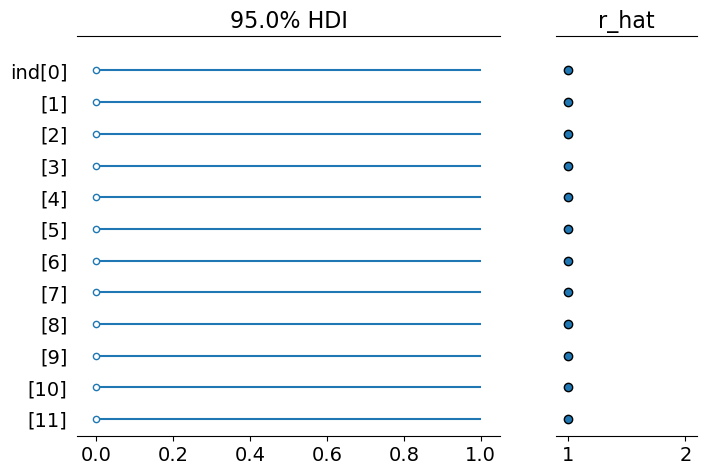

In [82]:
az.plot_forest(inference_results, var_names=["ind"], combined=True, hdi_prob=0.95, r_hat=True);

In [83]:
az.plot_forest(inference_results, var_names=["beta_raw"], combined=True, hdi_prob=0.95, r_hat=True);

### Effective Sample Size

Interpretation: 
- Low ESS:
    - A low ESS suggests that the samples might be correlated or that the sampler is struggling to explore the parameter space efficiently.
    - This can lead to less reliable inference results.
- High ESS:
    - A high ESS indicates that the samples are more independent, providing a more accurate representation of the posterior distribution.
    - This means that the information in your posterior distribution is well-represented by the samples.
    
Factors Affecting ESS:
- Model Complexity:
    - More complex models can lead to lower ESS.
- Sampling Algorithm:
    - The choice of MCMC algorithm can affect ESS.
    - Some algorithms might be more efficient in certain situations.
- Number of Samples:
    - Increasing the number of samples can generally improve ESS, but there's a trade-off with computational cost.
    
Typical Range:
- While there's no strict threshold for a "good" ESS, values significantly lower than the number of samples can be a cause for concern.
- A general rule of thumb is that the ESS should be at least 100 for reliable inference.
- However, this can vary depending on the specific context and the complexity of the model.

Bulk vs Tail ESS: 
- ESS Bulk:
    - This refers to the effective sample size (ESS) of the bulk of the posterior distribution.
    - It's a measure of how many independent draws the MCMC sampler has effectively produced.
- ESS Tail:
    - This refers to the ESS of the tails of the posterior distribution.
    - It's a measure of how well the sampler has explored the extreme values of the distribution.
    
- Values: 
    - Ideally, the ESS bulk and tail should be similar in magnitude.
    - A large difference between the two can indicate potential convergence issues or an insufficient number of samples.
    - If the ESS tail is significantly smaller than the ESS bulk, it suggests that the sampler may not have adequately explored the tails of the distribution.
- Shape:
    - Symmetrical:
        - If the posterior is roughly symmetrical, it suggests that the data is providing strong evidence for a particular range of parameter values.
    - Skewed:
        - A skewed posterior indicates that the data favors one tail of the distribution over the other.
        - This could be due to factors like outliers or non-linear relationships.
    - Multimodal:
        - A multimodal posterior suggests that the data supports multiple plausible parameter values.
        - This could be due to model misspecification or the presence of multiple local optima.  

Improving ESS:

- Increase the Number of Samples:
    - Run the MCMC sampler for longer.
- Consider a Different Sampler:
    - Experiment with different MCMC algorithms.
- Reparameterize the Model:
    - If possible, reparameterize the model to improve mixing.

In [84]:
def plot_ess(summary_df, variables, states):
    """Plots Effective Sample Size (ESS) for bulk and tail of
    specified variables across different covariate values.

    Args:
      summary_df (pd.DataFrame):
          A DataFrame containing the summary statistics 
          including ESS values for different variables and 
          covariates (states or variables).
          
      variables (list):
          A list of variable names to plot the ESS for.
          
      states (list):
          A list of state names (if plotting ESS by state).

    Returns:
        None:
            This function creates plots and does not return any value.
      
    Typical Usage Example: 
        This allows you to visually assess the convergence of the
        MCMC sampler for each variable and state, helping you identify
        potential issues with model fit or sampling efficiency.      
        
        plot_ess(summary_df, inference_variables, inference_states)
    """

    
    for i, var_name in enumerate(['beta', 'beta_raw', 'ind', 'mu']):
        pattern = f'{var_name}\[(\d+)\]'

        filtered_df = summary_df[summary_df.index.str.match(pattern)]
        
        fig, ax = plt.subplots(figsize=(20, 5), nrows=2, ncols=1, sharex=True)
        fig.suptitle(f"ESS bulk and tail: {var_name}")
            
        if var_name in ['beta', 'beta_raw', 'ind']:
            ax[0].plot(variables, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(variables, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=90)
            plt.show()
            
        else: 
            ax[0].plot(states, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(states, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=45)
            plt.show() 

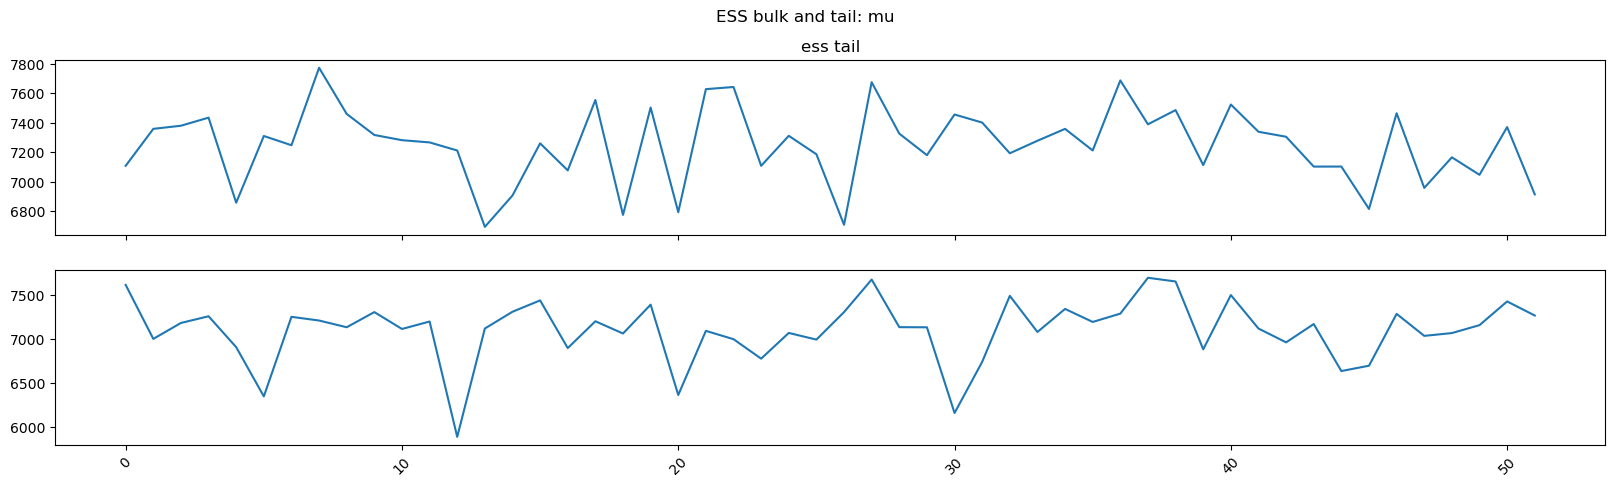

In [85]:
# Arviz method
# az.plot_ess(inference_results)
plot_ess(summary_df, inference_variables, inference_states)

### Trace Plots


- Density Plot:
    - Shape:
        - A symmetric, unimodal distribution indicates a well-defined posterior.
        - A skewed or multimodal distribution might suggest issues with the model or data.
    - Location:
        - The location of the peak indicates the most probable value of the parameter.
    - Spread:
        - The width of the distribution indicates the uncertainty around the parameter.
- Trace Plot:
    - Mixing:
        - The trace plot should show a well-mixed chain, meaning the sampler is exploring the parameter space effectively.
        - If the trace is stuck in a particular region, it might indicate convergence issues.
    - Stationarity:
        - The trace should appear stationary, meaning there are no clear trends or patterns over time.
        - A non-stationary trace might suggest that the sampler hasn't converged yet.
        
- Interpretation the Variables:
    - Beta:
        - The posterior distribution of beta indicates the importance of the corresponding features in the model.
        - A wider distribution suggests more uncertainty about the feature's importance.
        - Negative values indicate inverse relationships.
    - Beta_raw:
        - This represents the raw coefficients before feature selection.
        - A wider distribution might indicate that the feature is not strongly associated with the target variable.
    - Sigma:
        - The posterior distribution of sigma represents the uncertainty in the model's noise term.
        - A wider distribution indicates greater uncertainty.
        - Standard deviation of the noise term. A smaller value indicates less noise.
    - Ind:
        - The posterior distribution of ind represents the probability of each feature being included in the model.
        - A higher probability indicates a more important feature.
        - Indicator variables indicate whether a feature is included (1) or excluded (0) in the model.
    - Mu:
        - The posterior distribution of mu represents the uncertainty in the model's predictions.
        - Predicted mean values for the target variable.
    - Divergence:
        - Look for signs of divergence, such as sudden jumps in the trace plots or high R-hat values.

In [86]:
# Arviz method
# Left column are density plots which show the distribution of the parameter values.
# Right is the Trace Plot which plots the parameter values across MCMC iterations.
az.plot_trace(inference_results, var_names=["beta", "beta_raw", "sigma", "ind", "mu"]);

In [87]:
# def plot_result(
#     summary_df,
#     inference_variables, 
#     idx_pattern = r'beta\[(\d+)\]'
# ):
#     results = summary_df[summary_df.index.str.match(idx_pattern, regex=True)]
#     plt.plot(results, inference_variables)
#     plt.xticks(rotation=90)

#     plt.show()

### Posterior Distrubitions

array([[<Axes: title={'center': 'beta_raw\n0'}>,
        <Axes: title={'center': 'beta_raw\n1'}>,
        <Axes: title={'center': 'beta_raw\n2'}>],
       [<Axes: title={'center': 'beta_raw\n3'}>,
        <Axes: title={'center': 'beta_raw\n4'}>,
        <Axes: title={'center': 'beta_raw\n5'}>],
       [<Axes: title={'center': 'beta_raw\n6'}>,
        <Axes: title={'center': 'beta_raw\n7'}>,
        <Axes: title={'center': 'beta_raw\n8'}>],
       [<Axes: title={'center': 'beta_raw\n9'}>,
        <Axes: title={'center': 'beta_raw\n10'}>,
        <Axes: title={'center': 'beta_raw\n11'}>]], dtype=object)

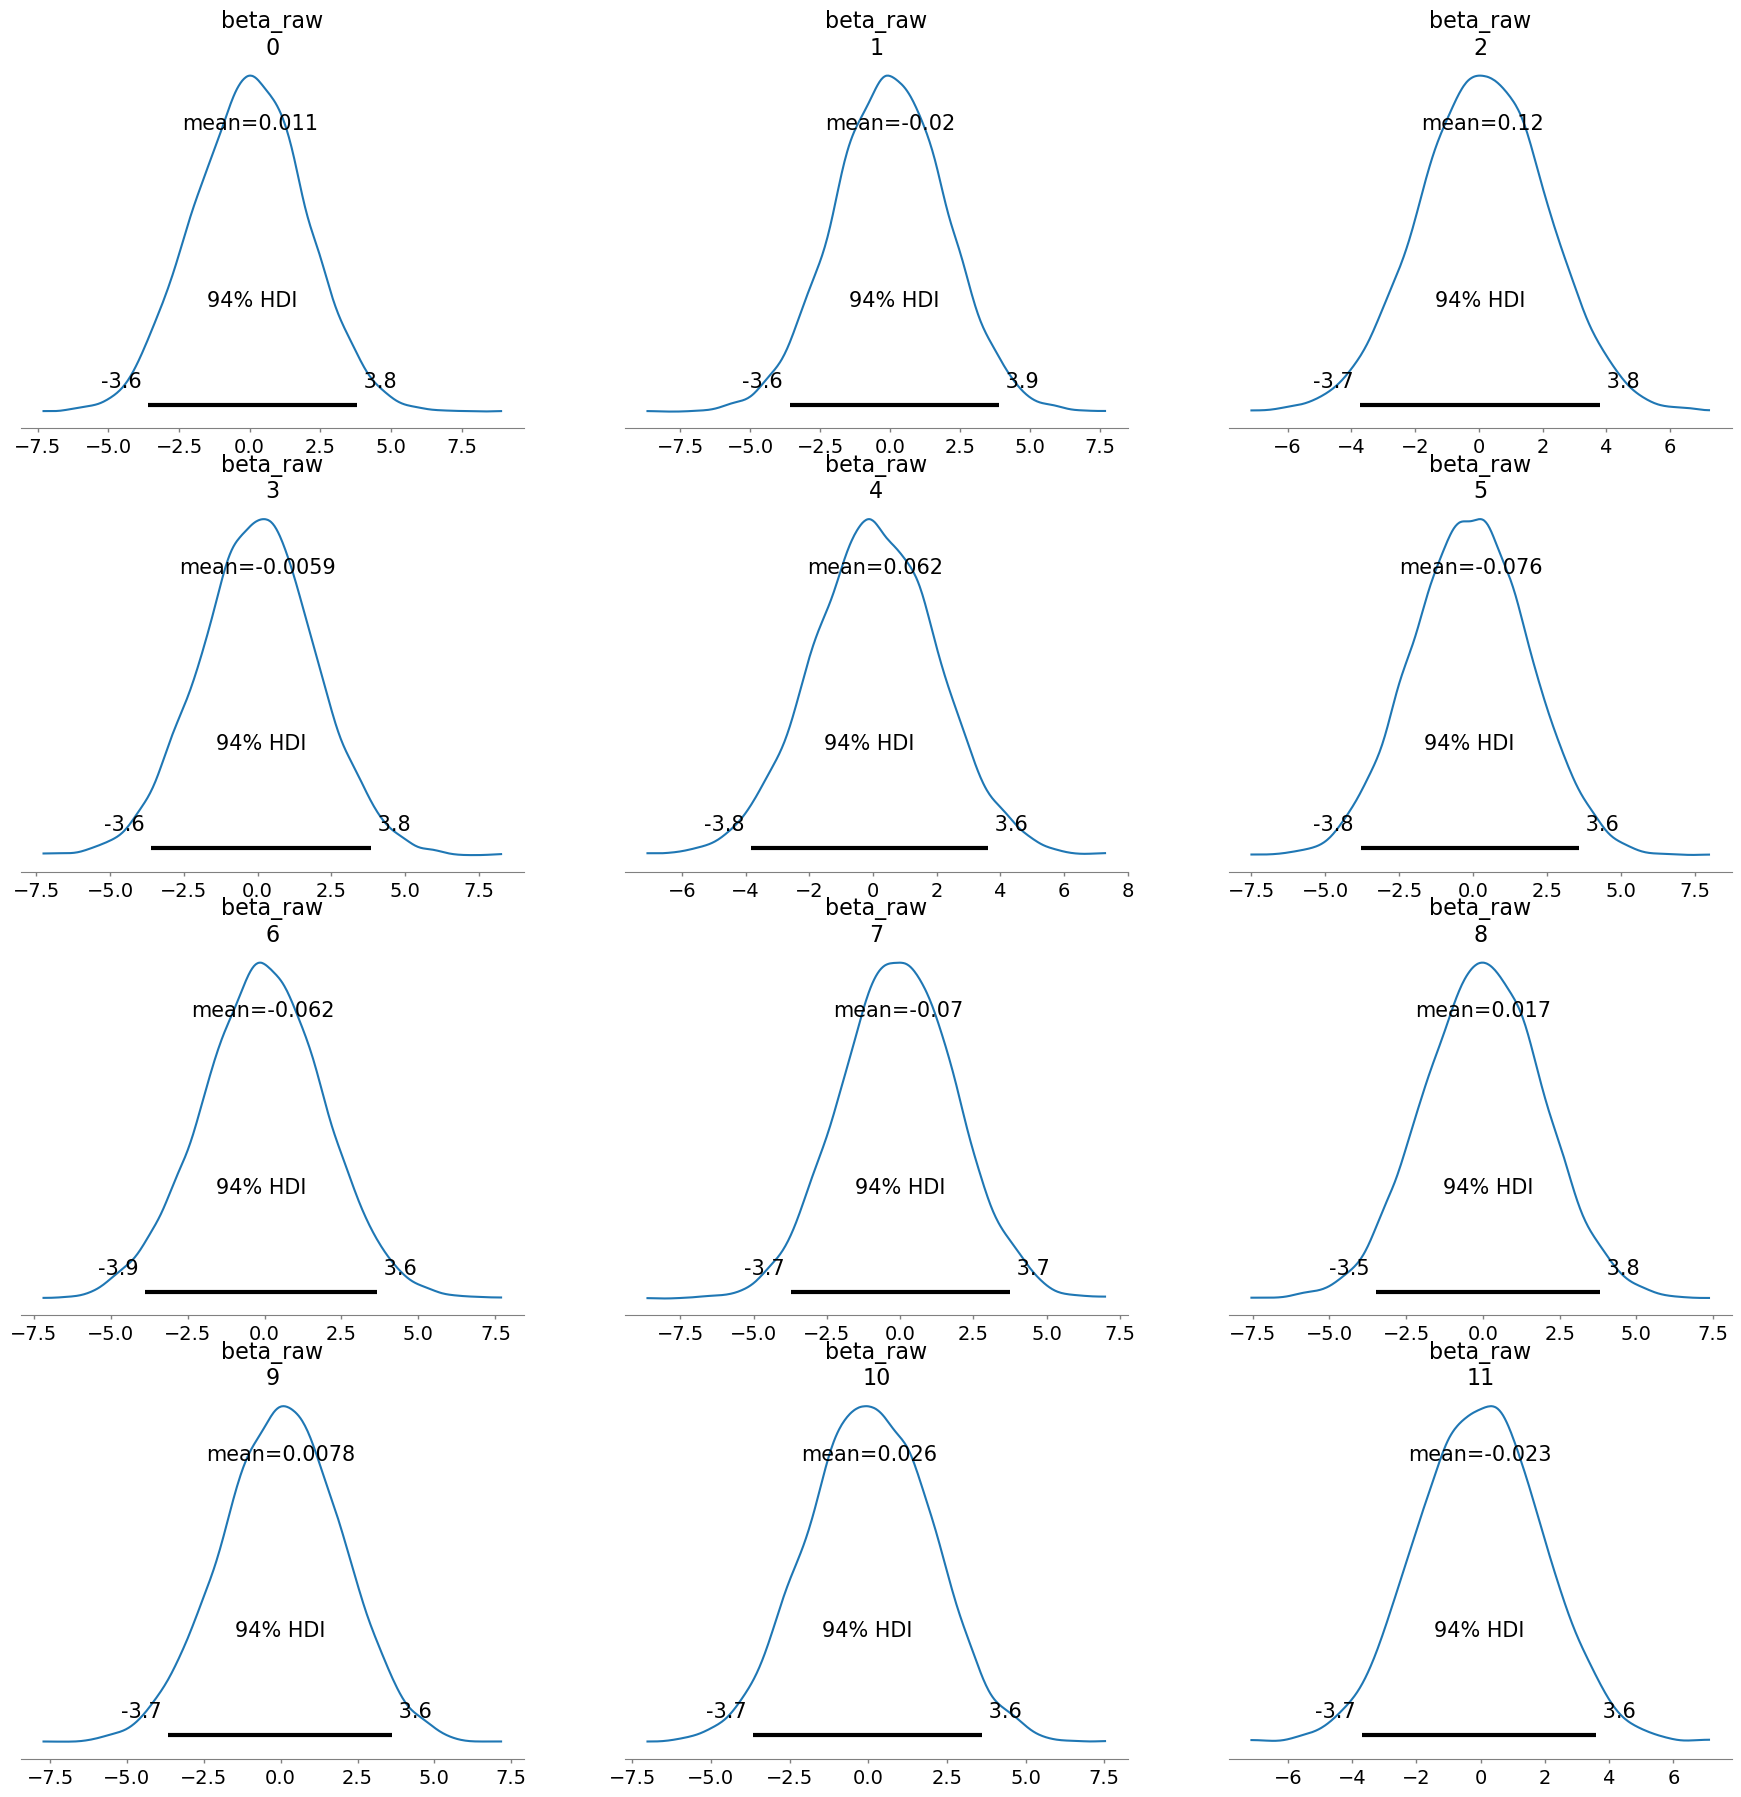

In [88]:
# az.plot_posterior(inference_results)
az.plot_posterior(inference_results, var_names=['beta_raw'])


In [89]:
az.plot_posterior(inference_results, var_names=['beta'])


array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'beta\n8'}>],
       [<Axes: title={'center': 'beta\n9'}>,
        <Axes: title={'center': 'beta\n10'}>,
        <Axes: title={'center': 'beta\n11'}>]], dtype=object)

In [90]:
az.plot_posterior(inference_results, var_names=['ind'])


array([[<Axes: title={'center': 'ind\n0'}>,
        <Axes: title={'center': 'ind\n1'}>,
        <Axes: title={'center': 'ind\n2'}>],
       [<Axes: title={'center': 'ind\n3'}>,
        <Axes: title={'center': 'ind\n4'}>,
        <Axes: title={'center': 'ind\n5'}>],
       [<Axes: title={'center': 'ind\n6'}>,
        <Axes: title={'center': 'ind\n7'}>,
        <Axes: title={'center': 'ind\n8'}>],
       [<Axes: title={'center': 'ind\n9'}>,
        <Axes: title={'center': 'ind\n10'}>,
        <Axes: title={'center': 'ind\n11'}>]], dtype=object)

### Model Fit

In [91]:
# # Log liklihood not in inference results. Need to add
# waic_score = az.waic(inference_results)  
# print(waic_score)

# loo_score = az.loo(inference_results)
# print(loo_score)

# ppc = az.from_pymc3(pm.sample_posterior_predictive(model, posterior_samples))


### Importance: np.abs(beta_means) * ind_means

- What is it? 
    - The importance variable typically represents a measure of the relative influence of different variables on a target variable in a Bayesian model.
    - It is often calculated by combining the posterior means of the coefficients (beta) with the inclusion probabilities (ind).
    - A higher importance value suggests that a variable is more likely to be influential in predicting the target variable.
    - The specific parameters that go into calculating importance can vary depending on the exact implementation, but generally include:
        - Posterior means of coefficients (beta): These represent the estimated effects of each variable on the target variable.
        - Inclusion probabilities (ind): These represent the probability that each variable is included in the model based on the posterior distribution.
- Notes: 
    - The importance metric is a relative measure and doesn't provide absolute values of effect size.
    - The typical range of values for the importance metric in Bayesian variable selection can vary widely depending on the specific problem, model complexity, and scale of the data.
    - Factors affecting the range:
        - Model complexity: More complex models with many variables and interactions might result in a wider range of importance values.
        - Data scale: The scale of the variables in the data can affect the scale of the coefficients and inclusion probabilities, which in turn affects the importance values.
        - Prior distributions: The choice of prior distributions for the coefficients and inclusion probabilities can influence the range of possible values.
- Higher values:
    - Variables with higher importance values are generally considered more influential in predicting the target variable.
    - This suggests that they have a stronger relationship with the outcome.
    - Variables with high importance might still have some degree of uncertainty associated with their effects, which can be assessed by examining the posterior distributions of their coefficients.
- Lower values:
    - Variables with lower importance values are less influential.
    - They might have weaker relationships or be less informative for predicting the target.
- Zero values:
    - Variables with an importance of zero are effectively excluded from the model, indicating that they have no significant impact on the target variable.

In [92]:
def plot_importance(
    importance,
    x_labels,
    importance_type
):
    """Creates a bar plot to visualize the importance of features.

    Args:
        importance (list):
            A list containing the importance scores for each feature.

        x_labels (list):
            A list of corresponding labels for the features.

        importance_type (str):
            A string describing the type of importance (e.g., gain, weight, etc.).

    Returns:
        None:
            This function creates a plot and does not return any value.
          
    Typical Usage Example: 
        This code will generate a bar chart representing the importance
        scores for each feature. The x-axis will display the feature labels
        rotated for readability, and the y-axis will represent the importance score.
    
        plot_importance(normalized_importance_1, x_labels, importance_type="Importance: Beta & Ind")
    
    """   
    plt.plot(importance, 'o')
    plt.suptitle(f"{importance_type}")
    plt.xlabel(x_labels)
    plt.xticks(range(len(importance)), x_labels, rotation=90)
    plt.show()

#### Calculate feature importance based on coefficient magnitude and inclusion probability

In [96]:
x_labels = list(df_variables.columns)


In [97]:
# posterior_means = az.summary(inference_results)['mean']
posterior_means = summary_df['mean']
posterior_std = summary_df['sd']

beta_means = posterior_means.loc[
    posterior_means.index.str.startswith('beta') & ~posterior_means.index.str.startswith('beta_raw')
]

beta_raw = posterior_means.loc[
    posterior_means.index.str.startswith('beta_raw')
]

beta_std = posterior_std.loc[
    posterior_std.index.str.startswith('beta') & ~posterior_std.index.str.startswith('beta_raw')
]

ind_means = posterior_means.loc[posterior_means.index.str.startswith('ind')]


In [98]:
importance_1 = np.multiply(ind_means.values.flatten(), np.abs(beta_means.values).flatten())
importance_2 = np.multiply(ind_means.values.flatten(), beta_means.values.flatten())
importance_3 = np.multiply(ind_means.values.flatten(), beta_raw.values.flatten())

# Normalize importance from 0-1. Is this necessary?
normalized_importance_1 = (importance_1 - importance_1.min()) / (importance_1.max() - importance_1.min())

# importance

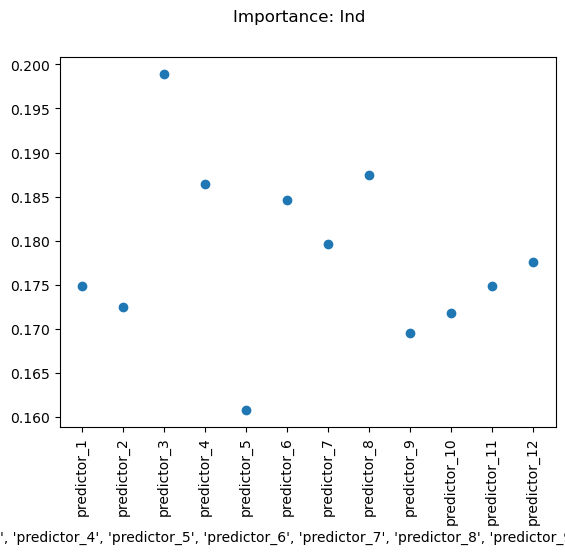

In [99]:
plot_importance(ind_means, x_labels, importance_type="Importance: Ind")

In [100]:
plot_importance(beta_raw, x_labels, importance_type="Importance: Beta Raw")

In [101]:

plot_importance(normalized_importance_1, x_labels, importance_type="Importance: Beta & Ind")

#### Calculate feature importance based on coefficient variance

In [ ]:
plot_importance(beta_means, x_labels, importance_type="Beta Means Only")

In [ ]:
plot_importance(ind_means, x_labels, importance_type="Ind Means Only")